In [ ]:
pip install eli5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

import os
import re
import numpy as np
import pandas as pd
import pickle
import time

from IPython.display import Image

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

import gensim #unstructured digital texts using unsupervised machine learning algorithms (LDA)
from gensim import corpora #It serves as an input for training a Model. The models use this training corpus to look for common themes and topics during training, initializing their internal model parameters
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score
# , plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.utils import plot_model

# import eli5 #Python package which helps to debug machine learning classifiers and explain their predictions
# from eli5.lime import TextExplainer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all_data = pd.read_csv("/content/drive/MyDrive/complaints.csv")
all_data.columns

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [ ]:
all_data.shape

(3367787, 18)

In [ ]:
important_data = all_data[["Complaint ID", "Product", "Consumer complaint narrative"]]
important_data.columns

Index(['Complaint ID', 'Product', 'Consumer complaint narrative'], dtype='object')

In [ ]:
important_data.head(10)

,Complaint ID,Product,Consumer complaint narrative
0,6603443,"Credit reporting, credit repair services, or o...",NaN
1,6603947,"Credit reporting, credit repair services, or o...",NaN
2,6601707,"Credit reporting, credit repair services, or o...",NaN
3,6600956,"Credit reporting, credit repair services, or o...",NaN
4,6605655,"Credit reporting, credit repair services, or o...",NaN
5,6605615,"Credit reporting, credit repair services, or o...",NaN
6,6605623,"Credit reporting, credit repair services, or o...",NaN
7,6600901,"Credit reporting, credit repair services, or o...",NaN
8,6601240,"Credit reporting, credit repair services, or o...",NaN
9,6601975,"Credit reporting, credit repair services, or o...",NaN


In [ ]:
important_data["Product"].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1639656
Debt collection                                                                  468002
Mortgage                                                                         371777
Credit card or prepaid card                                                      177337
Checking or savings account                                                      155735
Credit reporting                                                                 140429
Credit card                                                                       89190
Bank account or service                                                           86206
Student loan                                                                      73211
Money transfer, virtual currency, or money service                                51312
Vehicle loan or lease                                                             40734
Consumer Loan                   

# Pre Processing

In [ ]:
important_data_2 = important_data.rename(columns={"Product":"product", 'Consumer complaint narrative':'text',
                                                            "Complaint ID":"Complaint_ID"})
important_data_2.columns

Index(['Complaint_ID', 'product', 'text'], dtype='object')

In [ ]:
important_data_3 = important_data_2.dropna(inplace=False)
important_data_3.shape
important_data_3.head(15)

,Complaint_ID,product,text
85,6192011,"Credit reporting, credit repair services, or o...",Im resubmitting a complaint to you today to in...
90,6192034,"Credit reporting, credit repair services, or o...",On XX/XX/2022. I checked my credit report and ...
542,6363495,"Credit reporting, credit repair services, or o...",I XXXX XXXX XXXX am filing this complaint on b...
622,6522205,"Credit reporting, credit repair services, or o...","In accordance with the "" Fair Credit Reporting..."
666,6522688,"Credit reporting, credit repair services, or o...",A relative in XXXX used my social security num...
673,6492545,Debt collection,"Cascade Capital Funding , LLC incorrectly repo..."
681,6544514,"Credit reporting, credit repair services, or o...",This is my 5th endeavor to tell you that I am ...
700,6523010,"Credit reporting, credit repair services, or o...",You recently stated you did an investigation o...
758,6498901,Checking or savings account,As a customer of Regions Bank I have been disc...
807,6492035,Credit card or prepaid card,I am submitting this complaint because I had X...


In [ ]:
# important_data_3.loc[important_data_3['product'] == 'Credit reporting, credit repair services, or other personal consumer reports', 'product'] = 'Credit reporting'
# important_data_3.loc[important_data_3['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
# important_data_3.loc[important_data_3['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
# important_data_3.loc[important_data_3['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
# important_data_3.loc[important_data_3['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
# important_data_3.loc[important_data_3['product'] == 'Money transfers', 'product'] = 'Money transfer, virtual currency, or money service'
# important_data_3 = important_data_3[important_data_3.product != 'Other financial service']

In [ ]:
# important_data_3['product'].value_counts()

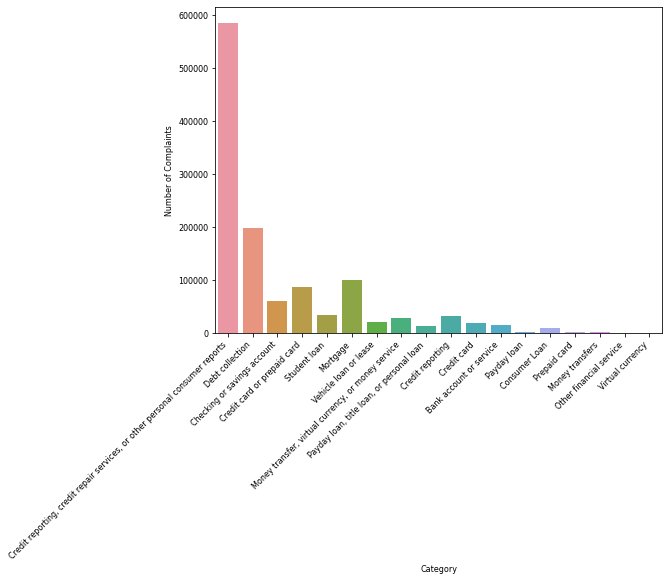

In [ ]:
def complaint_category_counts():
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 8})
    chart = sns.countplot('product', data = important_data_3)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')
    plt.ylabel('Number of Complaints', fontsize=8)
    plt.xlabel('Category', fontsize=8)
    return

complaint_category_counts()

In [ ]:
def removing_x_values(test_string): #Using Regex, removes 'X' and any dates
    new_string = re.sub(r'[X]+\/[X]+\/\d+|[X]+', "", test_string)
    return new_string

def remove_symbols(test_string):
    new_string = re.sub(r'[!"#$%&\'()*+,-.\/:;<=>?@\[\\\]^_`{\|}~]|[\d]+',"", test_string)
    return new_string

def tokenize(test_string):
    tokenizer = RegexpTokenizer(r'\w+|$[0-9.]+|\S+')
    tokenized_string = tokenizer.tokenize(test_string)
    return tokenized_string

def lowercase(tokenized_word_list):
    lower_case = [x.lower() for x in tokenized_word_list]
    return lower_case

def lemmatize(tokenized_word_list):
    lemmatized_words = []
    lemmatizer = WordNetLemmatizer()
    for x in tokenized_word_list:
        lemmatized_words.append(lemmatizer.lemmatize(x, pos='v'))
    return lemmatized_words

def remove_stopwords(tokenized_word_list):
    clean_list = [w for w in tokenized_word_list if not w in stop_words]
    return clean_list

In [ ]:
clean_data = important_data_3.copy(deep=True)

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
clean_data['text'] = important_data_3['text'].apply(removing_x_values)
clean_data['text'] = clean_data['text'].apply(remove_symbols)
clean_data['text'] = clean_data['text'].apply(tokenize)
clean_data['text'] = clean_data['text'].apply(lowercase)
clean_data['text'] = clean_data['text'].apply(lemmatize)
clean_data['text'] = clean_data['text'].apply(remove_stopwords)

In [ ]:
clean_data.head(10)

In [ ]:
clean_data["text_length"] = clean_data["text"].apply(len)
clean_data["text_length"].describe()

In [ ]:
clean_data = clean_data[clean_data["text_length"] >= 5]


In [ ]:
clean_data.head(10)

In [ ]:
clean_data_file = open('clean_complaints.pkl', 'ab')
pickle.dump(clean_data, clean_data_file)
clean_data_file.close()
print("Done !")

# Modelling Start

## LDA

In [ ]:
# Latent Dirichlet Allocation
def get_LDA_model(data, num_topics, passes):
    start_time = time.time()
    text_data = list(data['text'])
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    LDA_model = gensim.models.ldamulticore.LdaMulticore(
                               corpus=corpus,
                               num_topics=num_topics,
                               id2word=dictionary,
                               workers=6,
                               passes=passes)

    topics = LDA_model.print_topics(num_words=10)
    for x in topics:
        print(x)
        print("\n")
    return LDA_model, topics, corpus, dictionary

LDA_model, topics, corpus, dictionary = get_LDA_model(clean_data, 9, 10)

In [ ]:
# pip install gensim

In [ ]:
# pip install pyLDAvis


In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# Pickle the LDA model objects
with open('LDA_model.pkl', 'wb') as f:
    pickle.dump(LDA_model, f)
with open('complaint_data.pkl', 'wb') as f:
    pickle.dump(corpus, f)
with open('topics_data.pkl', 'wb') as f:
    pickle.dump(topics, f)
dictionary.save('dictionary.gensim')

## Model using LDA Topic Vectors


In [ ]:
# Training Vectors
text_data = list(clean_data['text'])

training_vectors = []
for i in range(len(text_data)):
    top_topics = LDA_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vectors = [top_topics[i][1] for i in range(9)]
    training_vectors.append(topic_vectors)

Multi-class Logistic Regression Classifier

In [ ]:
# Build a Logistic Regression Model using LDA Vectors
le = LabelEncoder()
scaler = StandardScaler()
Y = le.fit_transform(clean_data['product'])
X = np.array(training_vectors)
X_scaled = scaler.fit_transform(X)

X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(X_scaled, Y, test_size = 0.20, random_state = 1234)

lr_cv = LogisticRegressionCV(Cs=5,
                          class_weight='balanced',
                          cv=5,
                          max_iter=300,
                          multi_class='multinomial',
                          random_state=1234,
                          scoring='roc_auc_ovr_weighted',
                          solver='saga')

start_time = time.time()
lr_cv.fit(X_train_lr, Y_train_lr)
print("--- Time Taken: %s seconds ---" % (time.time() - start_time))

In [ ]:
print('Average Cross-Validation AUC OVR Weighted: ', lr_cv.scores_[1].mean(axis=0).max())

In [ ]:
with open('LR_CV_model.pkl', 'wb') as f:
    pickle.dump(lr_cv, f)
with open('X_LR.pkl', 'wb') as f:
    pickle.dump(X_scaled, f)
with open('Y_LR.pkl', 'wb') as f:
    pickle.dump(Y, f)

# LSTM Model in Keras



In [ ]:
def LSTMClassifier(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))

    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Shape of Input Data: ', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product']))

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)

    print('Shape of Output Data', Y_dl.shape)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    metrics = [Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())

    start_time = time.time()
    LSTM_Runs = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])
    print("--- Training Time Taken: %s seconds ---" % (time.time() - start_time))
    return model, LSTM_Runs

In [ ]:
LSTM_Model, LSTM_Runs = LSTMClassifier(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

In [ ]:
LSTM_model_json = LSTM_Model.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(LSTM_model_json)
LSTM_Model.save_weights("LSTM_model.h5")
print("Saved model to disk")

In [ ]:
plot_model(LSTM_Model, to_file='LSTM_Model_Architecture.png', show_shapes=True)

In [ ]:
def LSTMClassifierCV(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))
    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    metrics = [AUC(name='auc')]
    auc_per_fold = []
    fold_index = 1
    for train, test in kfold.split(X_train, Y_train):
        print()
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
        model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
        model.add(Dense(9, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
        if(fold_index == 1):
            print(model.summary())
        print("Training for Fold " + str(fold_index))
        model.fit(X_train[train], Y_train[train], epochs=epochs, batch_size=batch_size, validation_split=0)
        scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
        auc_per_fold.append(scores[1])
        fold_index += 1
    print('Average AUC: ' + str(np.mean(auc_per_fold)))

    return model, auc_per_fold

In [ ]:
LSTM_CV_Model, LSTM_CV_Scores = LSTMClassifierCV(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

In [ ]:
LSTM_CV_model_json = LSTM_CV_Model.to_json()
with open("LSTM_CV_model.json", "w") as json_file:
    json_file.write(LSTM_CV_model_json)
LSTM_CV_Model.save_weights("LSTM_CV_model.h5")
print("Saved model to disk")

In [ ]:
print(LSTM_CV_Scores)

### Convolutional Neural Network Classifier


In [ ]:
def CNNClassifier(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))

    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    metrics = [Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())

    CNN_Runs = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])
    return model, CNN_Runs

In [ ]:
CNN_Model, CNN_Runs = CNNClassifier(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

In [ ]:
plot_model(CNN_Model, to_file='CNN_Model.png', show_shapes=True)

In [ ]:
def CNNClassifierCV(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))
    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    metrics = [AUC(name='auc')]
    auc_per_fold = []
    fold_index = 1
    for train, test in kfold.split(X_train, Y_train):
        print()
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
        model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(9, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
        if(fold_index == 1):
            print(model.summary())
        print("Training for Fold " + str(fold_index))
        model.fit(X_train[train], Y_train[train], epochs=epochs, batch_size=batch_size, validation_split=0)
        scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
        auc_per_fold.append(scores[1])
        fold_index += 1
    print('Average AUC: ' + str(np.mean(auc_per_fold)))

    return model, auc_per_fold

In [ ]:
CNN_CV_Model, CNN_CV_Scores = CNNClassifierCV(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

In [ ]:
print(CNN_CV_Scores)

In [ ]:
CNN_CV_model_json = CNN_CV_Model.to_json()
with open("CNN_CV_model.json", "w") as json_file:
    json_file.write(CNN_CV_model_json)
CNN_CV_Model.save_weights("CNN_CV_model.h5")
print("Saved model to disk")

### Bi-Directional LSTM Classifier



In [ ]:
def BiLSTMClassifier(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))

    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product']))

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)

    print('Output Data Shape:', Y_dl.shape)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    metrics = [Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
    model.add(Bidirectional(LSTM(25, dropout=0.4, recurrent_dropout=0.4)))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())

    BiLSTM_Runs = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])
    return model, BiLSTM_Runs

In [ ]:
BiLSTM_Model, BiLSTM_Runs = BiLSTMClassifier(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

In [ ]:
plot_model(BiLSTM_Model, to_file='BiLSTM_Model.png', show_shapes=True)

In [ ]:
BiLSTM_model_json = BiLSTM_Model.to_json()
with open("BiLSTM_model.json", "w") as json_file:
    json_file.write(BiLSTM_model_json)
BiLSTM_Model.save_weights("BiLSTM_model.h5")
print("Saved model to disk")

In [ ]:
def BiLSTMClassifierCV(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))
    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    metrics = [AUC(name='auc')]
    auc_per_fold = []
    fold_index = 1
    for train, test in kfold.split(X_train, Y_train):
        print()
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
        model.add(Bidirectional(LSTM(25, dropout=0.4, recurrent_dropout=0.4)))
        model.add(Dense(9, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
        if(fold_index == 1):
            print(model.summary())
        print("Training for Fold " + str(fold_index))
        model.fit(X_train[train], Y_train[train], epochs=epochs, batch_size=batch_size, validation_split=0)
        scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
        auc_per_fold.append(scores[1])
        fold_index += 1
    print('Average AUC: ' + str(np.mean(auc_per_fold)))

    return model, auc_per_fold

In [ ]:
BiLSTM_CV_Model, BiLSTM_CV_Scores = BiLSTMClassifierCV(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

In [ ]:
BiLSTM_CV_model_json = BiLSTM_CV_Model.to_json()
with open("BiLSTM_CV_model.json", "w") as json_file:
    json_file.write(BiLSTM_CV_model_json)
BiLSTM_CV_Model.save_weights("BiLSTM_CV_Model.h5")
print("Saved model to disk")

In [ ]:
print(BiLSTM_CV_Scores)

In [ ]:
LSTM_CV_Model.save("LSTM_CV_Model_Full.h5")
BiLSTM_CV_Model.save("BiLSTM_CV_Model_Full.h5")
CNN_CV_Model.save("CNN_CV_Model_Full.h5")
print("Done !")

### Comparing Models


Here are the average cross-validation AUC scores for all the models that were tested above, rounded to 4 decimal places: <br><br>

LDA + Logistic Regression: **0.9195**<br>
LSTM:     **0.9808**<br>
CNN:      **0.9745**<br>
BiLSTM:   **0.9746**<br><br>

The Convolutional Neural Network would be a good choice to proceed with, since it achieves a good AUC with minimal training time.